## Importing Packages

In [1]:
import numpy as np
import pandas as pd
import cmdstanpy 
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import os
import json

from scipy.stats import gaussian_kde
import ipywidgets as widgets

In [2]:
sns.set_theme(style="whitegrid")
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['pdf.use14corefonts'] = True

## Choose Model

#### roots

In [3]:
root = './'
plots_root = root + 'Plots/'
datasets_root = root + 'Datasets/'
behavioural_data_root = root +  'behavioral_data/selected_data/' 
stan_files_root = root +  'stan files/' 
saved_models_root = root + 'stan_results/'

model_config = {}
plots_path = ''
dataset_path = ''
stan_file_path = ''
stan_output_dir = ''

#### read models configuration json file

In [4]:
with open("lba_models.json") as f:
    models = json.load(f)
    models_name = list(models.keys())

#### Choose and set model configuration

In [5]:
def SetModelAndPaths(model_name):
    global model_config
    global plots_path
    global dataset_path
    global stan_file_path
    global stan_output_dir
    model_config = models[model_name]
    plots_path = plots_root + model_config['plots_folder_name'] + '/'
    dataset_path = datasets_root + model_config['dataset_name']
    stan_file_path = stan_files_root + model_config['stan_file']
    stan_output_dir = saved_models_root + model_config['model_name'] + '/'
    os.path
    
    if not os.path.exists(plots_path):
        os.makedirs(plots_path)
        print("Directory " , plots_path ,  " Created ")
    else:    
        print("Directory " , plots_path ,  " already exists")
        
    if not os.path.exists(stan_output_dir):
        os.makedirs(stan_output_dir)
        print("Directory " , stan_output_dir ,  " Created ")
    else:    
        print("Directory " , stan_output_dir ,  " already exists")

widgets.interact(SetModelAndPaths, model_name=models_name);

interactive(children=(Dropdown(description='model_name', options=('LBA_cd', 'LBA_ndm', 'ANN-LBA_l_FC', 'ANN-LB…

In [6]:
model_config

{'model_name': 'ANN-LBA_full_s_FC',
 'stan_file': 'ANN-LBA/sigmoid_am_ndm.stan',
 'dataset_name': 'fastText_FC.csv',
 'plots_folder_name': 'ANN-LBA_full_s_FC',
 'transf_params': ['transf_mu_k_word',
  'transf_mu_k_nonword',
  'transf_mu_sp_trial_var_word',
  'transf_mu_sp_trial_var_nonword',
  'transf_mu_g',
  'transf_mu_m',
  'transf_mu_alpha',
  'transf_mu_b',
  'transf_mu_theta_1',
  'transf_mu_theta_2',
  'transf_mu_drift_variability']}

## Prepare data

Loading words and non-words with zipf and predicted probabilities

In [7]:
word_nword_df = pd.read_csv(dataset_path, header=None,
                            names =['string', 'freq',  'label', 'zipf',
                                    'category', 'word_prob', 'non_word_prob'])
word_nword_df

,string,freq,label,zipf,category,word_prob,non_word_prob
0,Ipe's,0,0,0.000000,NW,6.484266e-08,9.999998e-01
1,toothcamb,0,0,0.000000,NW,4.641062e-05,9.999536e-01
2,flicks,702,1,2.935287,LF,9.993498e-01,6.502719e-04
3,Samoar,0,0,0.000000,NW,1.966545e-06,9.999980e-01
4,lastened,0,0,0.000000,NW,1.107923e-04,9.998892e-01
...,...,...,...,...,...,...,...
74312,drased,0,0,0.000000,NW,6.662523e-05,9.999334e-01
74313,exorcism,238,1,3.274105,HF,9.999999e-01,7.543648e-08
74314,pobs,0,0,0.000000,NW,1.563252e-07,9.999999e-01
74315,undemonstrative,3,1,1.592864,LF,9.999452e-01,5.486609e-05


In [8]:
# Reading LDT Data
behavioural_df = pd.read_csv(behavioural_data_root + 'LDT_data_test.csv', header=None,
                             names=['accuracy', 'rt', 'string', 'response',
                                    'participant', 'minRT', 'participant_id'])
# Merging  behavioral dataframe with word_nonword_df to have words and non-words data with behavioral data
behavioural_df = pd.merge(behavioural_df, word_nword_df, on='string', how='left').dropna().reset_index(drop=True)
behavioural_df = behavioural_df.drop(['freq', 'participant'], axis=1)

In [9]:
behavioural_df.head()

,accuracy,rt,string,response,minRT,participant_id,label,zipf,category,word_prob,non_word_prob
0,1,0.502,stunt,1,0.362,1,1.0,3.963932,HF,1.000000,2.033012e-07
1,1,0.577,elastic,1,0.362,1,1.0,3.024228,HF,0.999996,4.324682e-06
2,1,0.518,now,1,0.362,1,1.0,6.504911,HF,0.999970,3.024556e-05
3,0,0.543,vaitresses,1,0.362,1,0.0,0.000000,NW,0.000069,9.999310e-01
4,1,0.556,sweetness,1,0.362,1,1.0,3.517143,HF,0.999996,4.047130e-06


Predicted probabilities of words and non-words in different conditions in all trials
across participants

## Stan Model and Estimation

Compiling stan model

In [12]:
lba_model = cmdstanpy.CmdStanModel(model_name=model_config['model_name'],
                                   stan_file=stan_file_path);

19:26:41 - cmdstanpy - INFO - compiling stan file E:\Workspace\Thesis\ANN-EAM\stan files\ANN-LBA\sigmoid_am_ndm.stan to exe file E:\Workspace\Thesis\ANN-EAM\stan files\ANN-LBA\sigmoid_am_ndm.exe
19:27:33 - cmdstanpy - INFO - compiled model executable: E:\Workspace\Thesis\ANN-EAM\stan files\ANN-LBA\sigmoid_am_ndm.exe
19:27:33 - cmdstanpy - WARNING - Stan compiler has produced 34 warnings:
19:27:33 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/Arash/AppData/Local/Temp/tmphn19pqib/tmpgkshhdgr.hpp C:/Users/Arash/AppData/Local/Temp/tmphn19pqib/tmpgkshhdgr.stan
Warning in 'C:/Users/Arash/AppData/Local/Temp/tmphn19pqib/tmpgkshhdgr.stan', line 109, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in 'C:/Users/Arash/AppData/Local/Tem

Preparing model's inputs

note that some inputs of data_dict might not be used depending on which model is used

In [13]:
N = len(behavioural_df)                                                    # For all models
participant = behavioural_df['participant_id'].to_numpy()                     # For all models
p = behavioural_df.loc[:, ['word_prob', 'non_word_prob']].to_numpy()       # predicted probabilites of words and non-words, for ANN-EAM models
frequency = behavioural_df['zipf'].to_numpy().astype(int)                  # zipf values For models with non-decision time or drift modulation
frequencyCondition = behavioural_df['category'].replace(["HF", "LF", "NW"], [1, 2, 3]).to_numpy() # For models with conditional drift
response = behavioural_df['response'].to_numpy().astype(int)               # for all models
rt = behavioural_df['rt'].to_numpy()                                       # for all models
minRT = behavioural_df['minRT'].to_numpy()                                 # for all models
RTbound = 0.1                                                              # for all models
Number_Of_Participants = len(set(behavioural_df['participant_id']))

k_priors = [0, 1, 1, 1]                  # All models with LBA
A_priors = [1, 2, 1, 1]                  # All models wtih LBA
ndt_priors = [0, 1, 1, 1];               # For models wtihout non-decision time modulation
g_priors = [-2, 1, 0, 1]                 # For models wtih non-decision time modulation
m_priors = [0, 0.5, 0, 1]                # For models wtih non-decision time modulation
drift_priors = [1, 2, 1, 1]              # For models withoud drift mapping functions (non ANN-EAM models)
alpha_priors = [0, 1, 1, 1]              # For models with drift mapping functions
b_priors = [0, 1, 1, 1]                  # For models with drift mapping functions with asymptote modulation and linear models
# There is a k parameter in LBA impelemention so we use theta as k parameter in sigmoid function
theta_priors = [2, 1, 1, 1]              # For models with sigmoid drift mapping functions (ANN-EAM models) (equivalent of k_priors in RDM and ANN-RDM)
sp_trial_var_priors = [1, 1, 0, 1]
drift_variability_priors = [1, 1, 1, 1]

# define input for the model
data_dict = {'N': N,
             'L': Number_Of_Participants,
             'participant': participant,
             'response': response,
             'rt': rt,
             'minRT': minRT,
             'RTbound': RTbound,
             'frequency': frequency,
             'frequencyCondition': frequencyCondition,
             'k_priors': k_priors,
             'A_priors': A_priors,
             'ndt_priors': ndt_priors,
             'g_priors': g_priors,
             'm_priors': m_priors,
             'drift_priors': drift_priors,
             'p': p,
             'alpha_priors': alpha_priors,
             'b_priors': b_priors,
             'k_priors': k_priors,
             'theta_priors': theta_priors,
             'sp_trial_var_priors': sp_trial_var_priors,
             'drift_variability_priors': drift_variability_priors
             }

# set sampling parameters
n_iter = 500
n_warmup = int(n_iter/2)
n_sample = int(n_iter/2)
n_chains = 2

Fitting the model

In [14]:
fit = lba_model.sample(data=data_dict,
                       iter_sampling=n_sample, 
                       iter_warmup=n_warmup,
                       chains=n_chains,
                       output_dir=stan_output_dir,
                       show_console=True)

19:27:36 - cmdstanpy - INFO - Chain [1] start processing
19:27:36 - cmdstanpy - INFO - Chain [2] start processing


Chain [2] method = sample (Default)
Chain [2] sample
Chain [1] method = sample (Default)
Chain [1] sample
Chain [1] num_samples = 250
Chain [1] num_warmup = 250
Chain [1] save_warmup = 0 (Default)
Chain [2] num_samples = 250
Chain [2] num_warmup = 250
Chain [2] save_warmup = 0 (Default)
Chain [2] thin = 1 (Default)
Chain [2] adapt
Chain [2] engaged = 1 (Default)
Chain [2] gamma = 0.050000000000000003 (Default)
Chain [2] delta = 0.80000000000000004 (Default)
Chain [1] thin = 1 (Default)
Chain [1] adapt
Chain [1] engaged = 1 (Default)
Chain [1] gamma = 0.050000000000000003 (Default)
Chain [1] delta = 0.80000000000000004 (Default)
Chain [1] kappa = 0.75 (Default)
Chain [1] t0 = 10 (Default)
Chain [1] init_buffer = 75 (Default)
Chain [2] kappa = 0.75 (Default)
Chain [2] t0 = 10 (Default)
Chain [2] init_buffer = 75 (Default)
Chain [2] term_buffer = 50 (Default)
Chain [2] window = 25 (Default)
Chain [2] algorithm = hmc (Default)
Chain [2] hmc
Chain [2] engine = nuts (Default)
Chain [2] nuts


20:00:31 - cmdstanpy - INFO - Chain [1] done processing


Chain [1] 
Chain [1] Elapsed Time: 885.801 seconds (Warm-up)
Chain [1] 1088.89 seconds (Sampling)
Chain [1] 1974.69 seconds (Total)
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 

20:02:49 - cmdstanpy - INFO - Chain [2] done processing
20:02:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: tmpgkshhdgr_model_namespace::log_prob: drift_word_t[372] is nan, but must be greater than or equal to 0.000000 (in 'C:/Users/Arash/AppData/Local/Temp/tmphn19pqib/tmpgkshhdgr.stan', line 182, column 4 to column 37)
	Exception: tmpgkshhdgr_model_namespace::log_prob: drift_word_t[372] is nan, but must be greater than or equal to 0.000000 (in 'C:/Users/Arash/AppData/Local/Temp/tmphn19pqib/tmpgkshhdgr.stan', line 182, column 4 to column 37)
	Exception: tmpgkshhdgr_model_namespace::log_prob: drift_word_t[372] is nan, but must be greater than or equal to 0.000000 (in 'C:/Users/Arash/AppData/Local/Temp/tmphn19pqib/tmpgkshhdgr.stan', line 182, column 4 to column 37)
	Exception: tmpgkshhdgr_model_namespace::log_prob: drift_word_t[372] is nan, but must be greater than or equal to 0.000000 (in 'C:/Users/Arash/AppData/Local/Temp/tmphn19pqib/tmpgkshhdgr.stan', line 182

Chain [2] 
Chain [2] Elapsed Time: 1000.28 seconds (Warm-up)
Chain [2] 1112.64 seconds (Sampling)
Chain [2] 2112.92 seconds (Total)
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 

20:02:50 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 15 divergent transitions (6.0%)
	Chain 1 had 17 iterations at max treedepth (6.8%)
	Chain 2 had 8 divergent transitions (3.2%)
	Chain 2 had 22 iterations at max treedepth (8.8%)
	Use function "diagnose()" to see further information.


## Loading Model

(In case model have been fitted before)

In [ ]:
# fit = cmdstanpy.from_csv(stan_output_dir)

## Model diagnostics

In [15]:
print("***hmc diagnostics:")
print(fit.diagnose(), flush=True)

***hmc diagnostics:
Processing csv files: E:\Workspace\Thesis\ANN-EAM\stan_results\ANN-LBA_full_s_FC\ANN-LBA_full_s_FC-20230314192736_1.csv, E:\Workspace\Thesis\ANN-EAM\stan_results\ANN-LBA_full_s_FC\ANN-LBA_full_s_FC-20230314192736_2.csv

Checking sampler transitions treedepth.
39 of 500 (7.80%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
23 of 500 (4.60%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

In [16]:
df = fit.summary()

print("***DF: ")
df

***DF: 


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-777.750000,0.764905,8.153660,-791.719000,-778.234000,-764.278000,113.629,0.051614,0.998394
mu_k_word,-0.648788,0.056324,0.750685,-1.919130,-0.663006,0.515954,177.636,0.080687,1.013550
mu_k_nonword,-0.267817,0.064703,0.710208,-1.473250,-0.242590,0.902284,120.483,0.054727,1.011730
mu_sp_trial_var_word,0.932250,0.029103,0.450493,0.227010,0.918351,1.676300,239.609,0.108837,1.012130
mu_sp_trial_var_nonword,1.354490,0.047048,0.583567,0.380574,1.369120,2.363880,153.849,0.069883,1.000150
...,...,...,...,...,...,...,...,...,...
log_lik[1837],-3.309790,0.009711,0.201335,-3.655090,-3.303940,-3.009260,429.827,0.195240,0.999463
log_lik[1838],-2.387050,0.006374,0.149045,-2.648490,-2.390590,-2.149920,546.856,0.248398,0.997525
log_lik[1839],-2.885640,0.009351,0.193933,-3.202740,-2.888180,-2.577960,430.096,0.195362,1.001090
log_lik[1840],-2.490320,0.006604,0.153387,-2.759250,-2.495710,-2.243680,539.517,0.245065,0.997740


In [17]:
counter = 0
print("***Rhat > 1.01: ")
for f in df["R_hat"]:
    if f >= 1.01 or f <= 0.9:
        counter+=1
print(counter)

***Rhat > 1.01: 
4572


In [18]:
df.loc[df['R_hat']>1.01].to_csv('logs/'+model_config['model_name']+'_rhat_log.csv')

In [19]:
df.loc[df['R_hat']>1.01]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
mu_k_word,-0.648788,0.056324,0.750685,-1.919130,-0.663006,0.515954,177.636,0.080687,1.01355
mu_k_nonword,-0.267817,0.064703,0.710208,-1.473250,-0.242590,0.902284,120.483,0.054727,1.01173
mu_sp_trial_var_word,0.932250,0.029103,0.450493,0.227010,0.918351,1.676300,239.609,0.108837,1.01213
mu_alpha,0.911649,0.037007,0.418169,0.196388,0.942099,1.555270,127.680,0.057996,1.03718
mu_theta_2,3.741010,0.042056,0.675371,2.645450,3.735110,4.789870,257.882,0.117138,1.01279
...,...,...,...,...,...,...,...,...,...
log_lik[800],-1.477880,0.008968,0.157924,-1.761050,-1.471360,-1.231190,310.131,0.140871,1.01106
log_lik[823],-1.609020,0.009477,0.164657,-1.903250,-1.605530,-1.354190,301.878,0.137122,1.01030
log_lik[876],-1.850220,0.009652,0.171780,-2.147250,-1.846560,-1.575120,316.718,0.143863,1.01033
log_lik[877],-1.695570,0.009680,0.168971,-1.988400,-1.693150,-1.429560,304.701,0.138404,1.01031


In [20]:
df.loc[df['R_hat']>1.01].describe()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
count,4572.000000,4572.000000,4572.000000,4572.000000,4572.000000,4572.000000,4572.000000,4572.000000,4572.000000
mean,1.481112,0.032266,0.413374,0.851899,1.445189,2.216354,176.457085,0.080152,1.012745
std,0.982936,0.018904,0.223683,0.648609,0.976488,1.365293,41.787383,0.018981,0.001882
min,-2.805980,0.004043,0.058102,-3.165550,-2.789870,-2.523050,78.095000,0.035473,1.010060
25%,0.706397,0.013991,0.178253,0.332700,0.670470,1.017870,149.182000,0.067763,1.011360
50%,1.018470,0.030243,0.389707,0.493808,0.976554,1.808460,159.455000,0.072429,1.012670
75%,2.171450,0.044071,0.549994,1.353670,2.119470,3.110860,204.855000,0.093051,1.014090
max,4.384610,0.097194,1.114780,2.887970,4.200760,6.491230,384.031000,0.174438,1.037180


## Check parameters

Parameters posterior plots

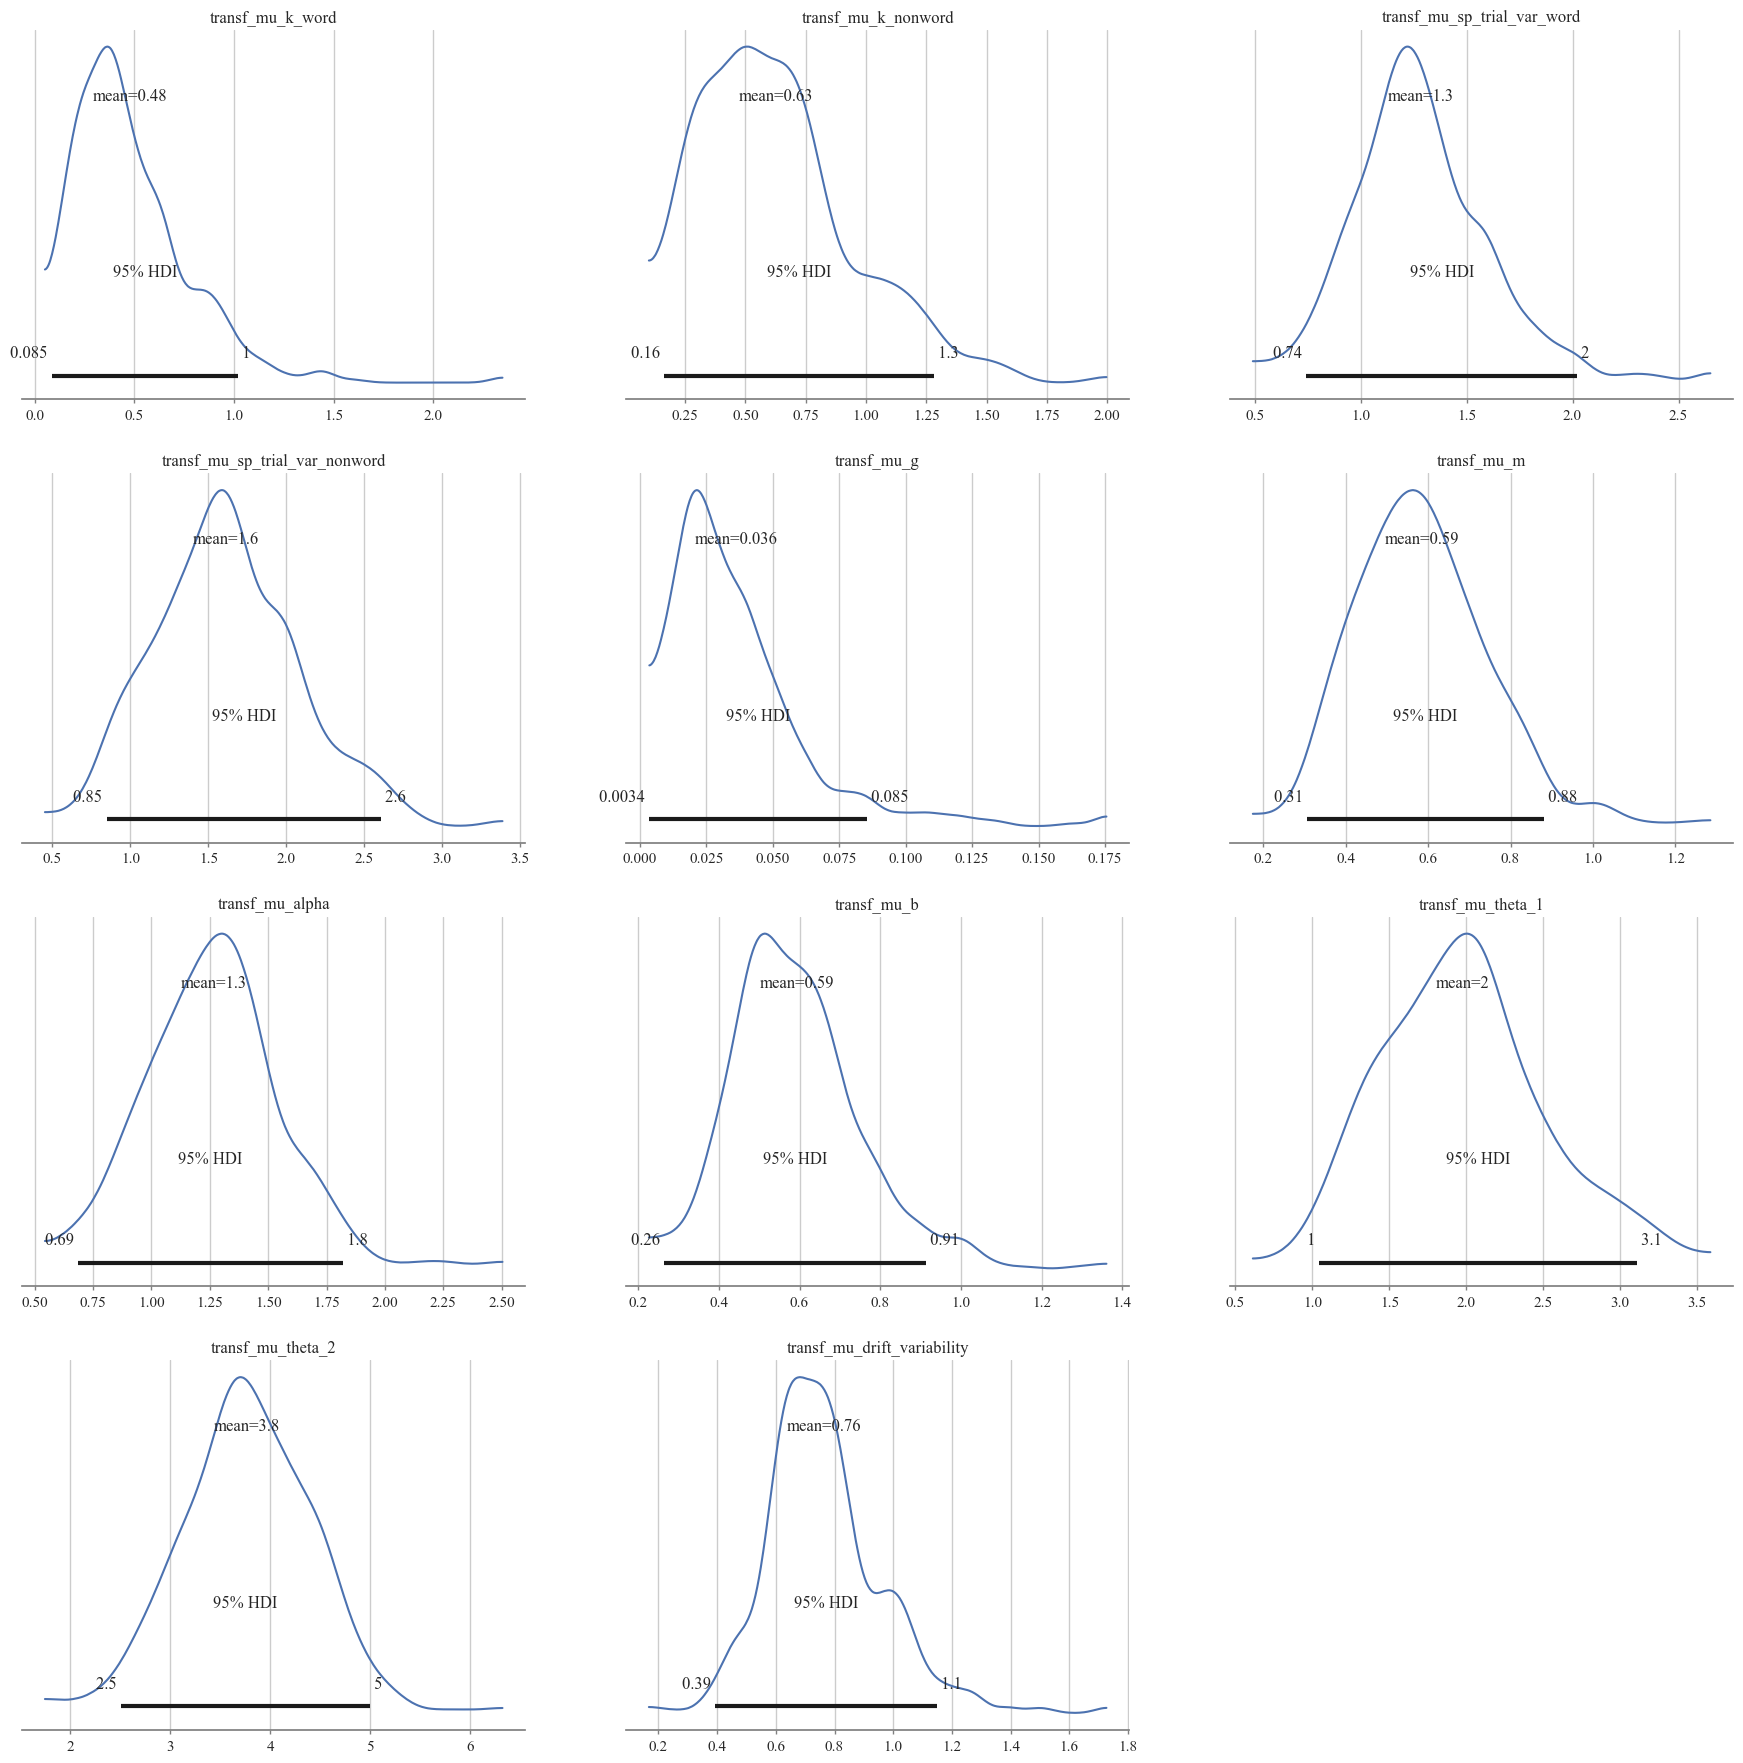

In [21]:
az.plot_posterior(fit, var_names=model_config['transf_params'],
                  hdi_prob=.95);
plt.savefig(plots_path + 'Parameters.pdf')

Loading model parameters for each trial

In [22]:
drift_word_t = fit.stan_variables()['drift_word_t']
drift_nonword_t = fit.stan_variables()['drift_nonword_t']
ndt_t = fit.stan_variables()['ndt_t']
drift_variability_t = fit.stan_variables()['drift_variability_t']
if model_config['model_name'] != "LBA":
    k_t_word = fit.stan_variables()['k_t_word']
    k_t_nonword = fit.stan_variables()['k_t_nonword']
    sp_t_word = fit.stan_variables()['sp_trial_var_t_word']
    sp_t_nonword = fit.stan_variables()['sp_trial_var_t_nonword']

else:
    k_t = fit.stan_variables()['k_t']
    sp_trial_var_t = fit.stan_variables()['sp_trial_var_t']

#### Models mean parameters in different conditions

In [23]:
v_HF_condition_w = drift_word_t[:, behavioural_df['category']=="HF"]
v_HF_condition_nw = drift_nonword_t[:, behavioural_df['category']=="HF"]
v_LF_condition_w = drift_word_t[:, behavioural_df['category']=="LF"]
v_LF_condition_nw = drift_nonword_t[:, behavioural_df['category']=="LF"]
v_NW_condition_w = drift_word_t[:, behavioural_df['category']=="NW"]
v_NW_condition_nw = drift_nonword_t[:, behavioural_df['category']=="NW"]

In [24]:
print('HF words, word drift mean and std:')
print(np.mean(np.mean(v_HF_condition_w, axis=1)), np.std(np.mean(v_HF_condition_w, axis=1)))
print('HF words, nonword drift mean and std:')
print(np.mean(np.mean(v_HF_condition_nw, axis=1)), np.std(np.mean(v_HF_condition_nw, axis=1)))
print('LF words word drift mean and std:')
print(np.mean(np.mean(v_LF_condition_w, axis=1)), np.std(np.mean(v_LF_condition_w, axis=1)))
print('LF words nonword drift mean and std:')
print(np.mean(np.mean(v_LF_condition_nw, axis=1)), np.std(np.mean(v_LF_condition_nw, axis=1)))
print('NW words word drift mean and std:')
print(np.mean(np.mean(v_NW_condition_w, axis=1)), np.std(np.mean(v_NW_condition_w, axis=1)))
print('NW words nonword drift mean and std:')
print(np.mean(np.mean(v_NW_condition_nw, axis=1)), np.std(np.mean(v_NW_condition_nw, axis=1)))

HF words, word drift mean and std:
2.615301481587744 0.4948636276755654
HF words, nonword drift mean and std:
1.375944170902507 0.2689515475593657
LF words word drift mean and std:
2.036963732635246 0.39288786934844755
LF words nonword drift mean and std:
1.3740249708196723 0.2676784402623007
NW words word drift mean and std:
0.6953012680782192 0.14871369986700186
NW words nonword drift mean and std:
2.6948611051468814 0.5006356602341521


In [25]:
if model_config['model_name'] != "LBA":
    sp_HF_condition_w = sp_t_word[:, behavioural_df['category']=="HF"]
    sp_HF_condition_nw = sp_t_nonword[:, behavioural_df['category']=="HF"]
    sp_LF_condition_w = sp_t_word[:, behavioural_df['category']=="LF"]
    sp_LF_condition_nw = sp_t_nonword[:, behavioural_df['category']=="LF"]
    sp_NW_condition_w = sp_t_word[:, behavioural_df['category']=="NW"]
    sp_NW_condition_nw = sp_t_nonword[:, behavioural_df['category']=="NW"]
else:
    sp_HF_condition = sp_trial_var_t[:, behavioural_df['category']=="HF"]
    sp_LF_condition = sp_trial_var_t[:, behavioural_df['category']=="LF"]
    sp_NW_condition = sp_trial_var_t[:, behavioural_df['category']=="NW"]

In [26]:
if model_config['model_name'] != "LBA":
    print('HF words, word starting point mean and std:')
    print(np.mean(np.mean(sp_HF_condition_w, axis=1)), np.std(np.mean(sp_HF_condition_w, axis=1)))
    print('HF words, nonword starting point mean and std:')
    print(np.mean(np.mean(sp_HF_condition_nw, axis=1)), np.std(np.mean(sp_HF_condition_nw, axis=1)))
    print('LF words word starting point mean and std:')
    print(np.mean(np.mean(sp_LF_condition_w, axis=1)), np.std(np.mean(sp_LF_condition_w, axis=1)))
    print('LF words nonword starting point mean and std:')
    print(np.mean(np.mean(sp_LF_condition_nw, axis=1)), np.std(np.mean(sp_LF_condition_nw, axis=1)))
    print('NW words word starting point mean and std:')
    print(np.mean(np.mean(sp_NW_condition_w, axis=1)), np.std(np.mean(sp_NW_condition_w, axis=1)))
    print('NW words nonword starting point mean and std:')
    print(np.mean(np.mean(sp_NW_condition_nw, axis=1)), np.std(np.mean(sp_NW_condition_nw, axis=1)))
else:
    print('HF words, starting point mean and std:')
    print(np.mean(np.mean(sp_HF_condition, axis=1)), np.std(np.mean(sp_HF_condition, axis=1)))
    print('LF words starting point mean and std:')
    print(np.mean(np.mean(sp_LF_condition, axis=1)), np.std(np.mean(sp_LF_condition, axis=1)))
    print('NW words starting point mean and std:')
    print(np.mean(np.mean(sp_NW_condition, axis=1)), np.std(np.mean(sp_NW_condition, axis=1)))

HF words, word starting point mean and std:
1.3195909372869081 0.2577564404868727
HF words, nonword starting point mean and std:
1.7833433649777164 0.3444778819904981
LF words word starting point mean and std:
1.3169359489999999 0.25816902271545783
LF words nonword starting point mean and std:
1.7688239357659836 0.3410419540337387
NW words word starting point mean and std:
1.302784297303823 0.2549009935475089
NW words nonword starting point mean and std:
1.7491748917158947 0.3386566971490892


In [27]:
if model_config['model_name'] != "LBA":
    k_HF_condition_w = k_t_word[:, behavioural_df['category']=="HF"]
    k_HF_condition_nw = k_t_nonword[:, behavioural_df['category']=="HF"]
    k_LF_condition_w = k_t_word[:, behavioural_df['category']=="LF"]
    k_LF_condition_nw = k_t_nonword[:, behavioural_df['category']=="LF"]
    k_NW_condition_w = k_t_word[:, behavioural_df['category']=="NW"]
    k_NW_condition_nw = k_t_nonword[:, behavioural_df['category']=="NW"]

    t_HF_condition_w = sp_HF_condition_w + sp_HF_condition_w
    t_HF_condition_nw = sp_HF_condition_nw + sp_HF_condition_nw
    t_LF_condition_w = sp_LF_condition_w + sp_LF_condition_w
    t_LF_condition_nw = sp_LF_condition_nw + sp_LF_condition_nw
    t_NW_condition_w = sp_NW_condition_w + sp_NW_condition_w
    t_NW_condition_nw = sp_NW_condition_nw + sp_NW_condition_nw
else:
    k_HF_condition = k_t[:, behavioural_df['category']=="HF"]
    k_LF_condition = k_t[:, behavioural_df['category']=="LF"]
    k_NW_condition = k_t[:, behavioural_df['category']=="NW"]

    t_HF_condition = sp_HF_condition + k_HF_condition
    t_LF_condition = sp_LF_condition + k_LF_condition
    t_NW_condition = sp_NW_condition + k_NW_condition

In [28]:
if model_config['model_name'] != "LBA":
    print('HF words, word threshold mean and std:')
    print(np.mean(np.mean(t_HF_condition_w, axis=1)), np.std(np.mean(t_HF_condition_w, axis=1)))
    print('HF words, nonword threshold mean and std:')
    print(np.mean(np.mean(t_HF_condition_nw, axis=1)), np.std(np.mean(t_HF_condition_nw, axis=1)))
    print('LF words word threshold mean and std:')
    print(np.mean(np.mean(t_LF_condition_w, axis=1)), np.std(np.mean(t_LF_condition_w, axis=1)))
    print('LF words nonword threshold mean and std:')
    print(np.mean(np.mean(t_LF_condition_nw, axis=1)), np.std(np.mean(t_LF_condition_nw, axis=1)))
    print('NW words word threshold mean and std:')
    print(np.mean(np.mean(t_NW_condition_w, axis=1)), np.std(np.mean(t_NW_condition_w, axis=1)))
    print('NW words nonword threshold mean and std:')
    print(np.mean(np.mean(t_NW_condition_nw, axis=1)), np.std(np.mean(t_NW_condition_nw, axis=1)))
else:
    print('HF words,  threshold mean and std:')
    print(np.mean(np.mean(t_HF_condition, axis=1)), np.std(np.mean(t_HF_condition, axis=1)))
    print('LF words threshold mean and std:')
    print(np.mean(np.mean(t_LF_condition, axis=1)), np.std(np.mean(t_LF_condition, axis=1)))
    print('NW words word threshold mean and std:')
    print(np.mean(np.mean(t_NW_condition, axis=1)), np.std(np.mean(t_NW_condition, axis=1)))

HF words, word threshold mean and std:
2.6391818745738163 0.5155128809737454
HF words, nonword threshold mean and std:
3.566686729955433 0.6889557639809962
LF words word threshold mean and std:
2.6338718979999998 0.5163380454309157
LF words nonword threshold mean and std:
3.5376478715319672 0.6820839080674774
NW words word threshold mean and std:
2.605568594607646 0.5098019870950178
NW words nonword threshold mean and std:
3.4983497834317894 0.6773133942981784


In [29]:
if model_config['model_name'] != "LBA":
    bias_HF_condition_w = t_HF_condition_w - sp_HF_condition_w
    bias_HF_condition_nw = t_HF_condition_nw - sp_HF_condition_nw
    bias_LF_condition_w = t_LF_condition_w - sp_LF_condition_w
    bias_LF_condition_nw = t_LF_condition_nw - sp_LF_condition_nw
    bias_NW_condition_w = t_NW_condition_w - sp_NW_condition_w
    bias_NW_condition_nw = t_NW_condition_nw - sp_NW_condition_nw

In [30]:
if model_config['model_name'] != "LBA":
    print('HF words, word bias mean and std:')
    print(np.mean(np.mean(bias_HF_condition_w, axis=1)), np.std(np.mean(bias_HF_condition_w, axis=1)))
    print('HF words, nonword bias mean and std:')
    print(np.mean(np.mean(bias_HF_condition_nw, axis=1)), np.std(np.mean(bias_HF_condition_nw, axis=1)))
    print('LF words word bias mean and std:')
    print(np.mean(np.mean(bias_LF_condition_w, axis=1)), np.std(np.mean(bias_LF_condition_w, axis=1)))
    print('LF words nonword bias mean and std:')
    print(np.mean(np.mean(bias_LF_condition_nw, axis=1)), np.std(np.mean(bias_LF_condition_nw, axis=1)))
    print('NW words word bias mean and std:')
    print(np.mean(np.mean(bias_NW_condition_w, axis=1)), np.std(np.mean(bias_NW_condition_w, axis=1)))
    print('NW words nonword bias mean and std:')
    print(np.mean(np.mean(bias_NW_condition_nw, axis=1)), np.std(np.mean(bias_NW_condition_nw, axis=1)))

HF words, word bias mean and std:
1.3195909372869081 0.2577564404868727
HF words, nonword bias mean and std:
1.7833433649777164 0.3444778819904981
LF words word bias mean and std:
1.3169359489999999 0.25816902271545783
LF words nonword bias mean and std:
1.7688239357659836 0.3410419540337387
NW words word bias mean and std:
1.302784297303823 0.2549009935475089
NW words nonword bias mean and std:
1.7491748917158947 0.3386566971490892


In [31]:
ndt_HF_condition = ndt_t[:, behavioural_df['category']=="HF"]
ndt_LF_condition = ndt_t[:, behavioural_df['category']=="LF"]
ndt_NW_condition = ndt_t[:, behavioural_df['category']=="NW"]

In [32]:
print('HF words ndt mean and std:')
print(np.mean(np.mean(ndt_HF_condition, axis=1)), np.std(np.mean(ndt_HF_condition, axis=1)))
print('LF words ndt mean and std:')
print(np.mean(np.mean(ndt_LF_condition, axis=1)), np.std(np.mean(ndt_LF_condition, axis=1)))
print('Non Words ndt mean and std:')
print(np.mean(np.mean(ndt_NW_condition, axis=1)), np.std(np.mean(ndt_NW_condition, axis=1)))

HF words ndt mean and std:
0.19835733286908078 0.018167251692209282
LF words ndt mean and std:
0.20266944365983608 0.01990423875578057
Non Words ndt mean and std:
0.20898456383903397 0.02054766139760044


## Calculating metrics

In [33]:
def calculate_waic(log_likelihood, pointwise=False):
    """
    Returns model comparisions' metrics.
    
    Parameters
    ----------
        log_likelihood: np.array
            log_likelihood of each trial
        max_rt: float
            maximum acceptable rt
        min_rt: float
             minimum acceptable rt
             
    Optional Parameters
    ----------------
    pointwise: float
        if true pointwise waic will be calculated
        
    Returns
    -------
        out:  a dictionary containing lppd, waic, waic_se and pointwise_waic    
    """
    likelihood = np.exp(log_likelihood)

    mean_l = np.mean(likelihood, axis=0) # N observations

    pointwise_lppd = np.log(mean_l)
    lppd = np.sum(pointwise_lppd)

    pointwise_var_l = np.var(log_likelihood, axis=0) # N observations
    var_l = np.sum(pointwise_var_l)

    pointwise_waic = - 2*pointwise_lppd +  2*pointwise_var_l
    waic = -2*lppd + 2*var_l
    waic_se = np.sqrt(log_likelihood.shape[1] * np.var(pointwise_waic))

    if pointwise:
        out = {'lppd':lppd,
               'p_waic':var_l,
               'waic':waic,
               'waic_se':waic_se,
               'pointwise_waic':pointwise_waic}
    else:
        out = {'lppd':lppd,
               'p_waic':var_l,
                'waic':waic,
                'waic_se':waic_se}
    return out

In [34]:
log_likelihood = fit.stan_variables()['log_lik']
print(calculate_waic(log_likelihood))

{'lppd': -711.3041504252155, 'p_waic': 44.35117037452001, 'waic': 1511.3106415994712, 'waic_se': 102.4797835104031}


## Simulating LBA with estimated parameters

In [35]:
def random_lba_2A(word_drift, nonword_drift, sp_trial_var_word, sp_trial_var_nonword,
                  ndt, k_word, k_nonword, drift_trial_var):
    """Simulates behavior (rt and accuracy) according to the Linear Ballistic Accumulator.
    Parameters
    ----------
    word_drift : numpy.ndarray
        Drift-rate of the Linear Ballistic Accumulator - correct responses. 1D array of floats.
    nonword_drift : numpy.ndarray
        Drift-rate of the Linear Ballistic Accumulator - incorrect responses. 1D array of floats.
    sp_trial_var_word : float
        Starting point variability of the Linear Ballistic Accumulator for words. Also called A.
    sp_trial_var_nonword : float
        Starting point variability of the Linear Ballistic Accumulator for non-words. Also called A.    
    ndt : float
        Non-decision time of the Linear Ballistic Accumulator. Also called tau.
    k_word : float
        Distance between starting point variability and threshold for words.
    k_nonword : float
        Distance between starting point variability and threshold for non-words.
    drift_trial_var : numpy.ndarray, default None
        The drift rate trial variability. 1D array of 0s and 1s.
    Returns
    -------
    rt : numpy.ndarray
        Shape is the same as the input parameters.
        Contains simulated response times according to the Linear Ballistic Accumulator.
        Every element corresponds to the set of parameters given as input with the same shape.
    resp: numpy.ndarray
        Shape is the same as the input parameters.
        Contains simulated response according to the Linear Ballistic Accumulator.
        Every element corresponds to the set of parameters given as input with the same shape.
    """
    shape = word_drift.shape
    resp = np.empty(shape)
    rt = np.empty(shape)
    resp[:] = np.nan
    rt[:] = np.nan

    b_word = k_word + sp_trial_var_word
    b_nonword = k_nonword + sp_trial_var_nonword
    one_pose = True
    v_word = np.array(word_drift)
    v_nonword = np.array(nonword_drift)

    # this while loop might be wrong
    while one_pose:
        ind = np.logical_and(v_word < 0, v_nonword < 0)
        if drift_trial_var is None:
            v_word[ind] = np.random.normal(word_drift[ind], np.ones(word_drift[ind].shape))
            v_nonword[ind] = np.random.normal(nonword_drift[ind], np.ones(nonword_drift[ind].shape))
        else:
            v_word[ind] = np.random.normal(word_drift[ind], drift_trial_var[ind])
            v_nonword[ind] = np.random.normal(nonword_drift[ind], drift_trial_var[ind])

        one_pose = np.sum(ind) > 0

    start_word = np.random.uniform(np.zeros(sp_trial_var_word.shape), sp_trial_var_word)
    start_non_word = np.random.uniform(np.zeros(sp_trial_var_nonword.shape), sp_trial_var_nonword)

    ttf_word = (b_word - start_word) / v_word
    ttf_nonword = (b_nonword - start_non_word) / v_nonword

    ind = np.logical_and(ttf_word <= ttf_nonword, 0 < ttf_word)
    resp[ind] = 1
    rt[ind] = ttf_word[ind] + ndt[ind]

    ind = np.logical_and(ttf_nonword < 0, 0 < ttf_word)
    resp[ind] = 1
    rt[ind] = ttf_word[ind] + ndt[ind]

    ind = np.logical_and(ttf_nonword < ttf_word, 0 < ttf_nonword)
    resp[ind] = 0
    rt[ind] = ttf_nonword[ind] + ndt[ind]

    ind = np.logical_and(ttf_word < 0, 0 < ttf_nonword)
    resp[ind] = 0
    rt[ind] = ttf_nonword[ind] + ndt[ind]

    return rt, resp

Simulating LBA with estimated parameters

In [36]:
if model_config['model_name'] != "LBA":
    pp_rt, pp_response = random_lba_2A(drift_word_t, drift_nonword_t, sp_t_word, sp_t_nonword,
                                       ndt_t, k_t_word, k_t_nonword, drift_variability_t)
else:
    pp_rt, pp_response = random_lba_2A(drift_word_t, drift_nonword_t, sp_trial_var_t, sp_trial_var_t,
                                       ndt_t, k_t, k_t, drift_variability_t)

In [37]:
def bci(x, alpha=0.05):
    """
    Calculate Bayesian credible interval (BCI).
    
    Parameters
    ----------
    x : array-like
        An array containing MCMC samples.
    
    Optional Parameters
    -------------------
    alpha : float, default 0.05
        Desired probability of type I error.
    
    Returns
    -------
    interval : numpy.ndarray
        Array containing the lower and upper bounds of the bci interval.
    """
    interval = np.nanpercentile(x, [(alpha/2)*100, (1-alpha/2)*100])

    return interval

In [38]:
# Predicted Data
tmp1 = pd.DataFrame(pp_rt,
                    index=pd.Index(np.arange(1, len(pp_rt)+1), name='sample'),
                    columns=pd.MultiIndex.from_product((['rt'],
                                                        np.arange(pp_rt.shape[1])),
                                                        names=['variable', 'trial']))
tmp2 = pd.DataFrame(pp_response,
                    index=pd.Index(np.arange(1, len(pp_response)+1), name='sample'),
                    columns=pd.MultiIndex.from_product((['response'],
                                                        np.arange(pp_response.shape[1])),
                                                               names=['variable', 'trial']))
predictedData = pd.concat((tmp1, tmp2), axis=1)

In [39]:
def GetDfs(category = "HF|LF|NW", response = "1|0",
           accuracy = "1|0", pred_df_type='rt'):
    
    experiment_df =  behavioural_df.loc[(behavioural_df['category'].str.match(category)) &
                  (behavioural_df['response'].apply(str).str.match(str(response))) &
                  (behavioural_df['accuracy'].apply(str).str.match(str(accuracy)))]
    
    if response == "1|0":
        predicted_df = predictedData[pred_df_type]\
        [behavioural_df.loc[behavioural_df['category'].str.match(category)].index] 
    else:
        predicted_df = predictedData[pred_df_type][predictedData['response']== int(response)]\
        [behavioural_df.loc[behavioural_df['category'].str.match(category)].index] 

    return (experiment_df, predicted_df)

## RT Quantiles Posterior Predictions Checks

In [40]:
quantiles = [.1, .3, .5, .7, .9]

### All Trials

In [41]:
exp_all_trials, pred_all_trials = GetDfs()

In [42]:
all_quantiles_ex = exp_all_trials['rt'].quantile(quantiles)
all_quantiles_pred = pred_all_trials.quantile(quantiles, axis=1).T
all_predicted_bci = np.array([bci(all_quantiles_pred[x]) for x in quantiles])

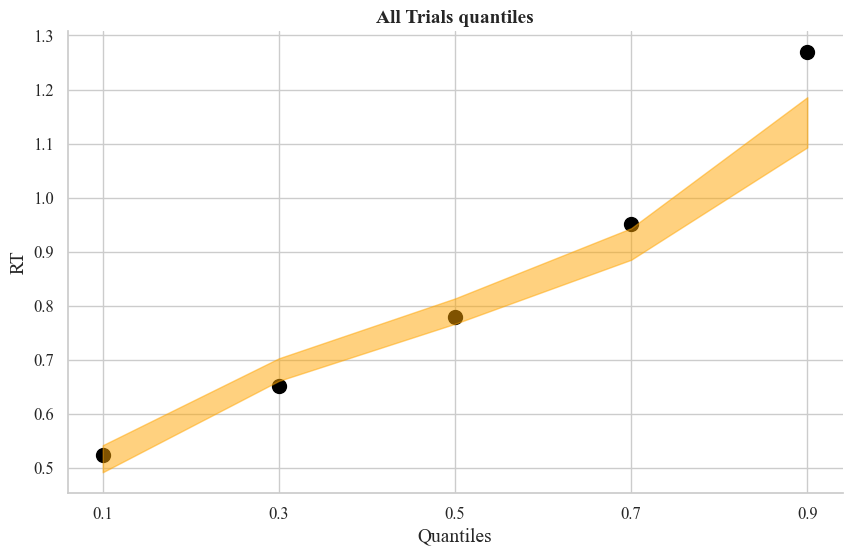

In [43]:
fig, ax = plt.subplots(figsize=(10,6))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

ax.set_title('All Trials quantiles', fontweight="bold", size=14)
ax.scatter(quantiles, all_quantiles_ex, color='black', s=100)

ax.fill_between(quantiles,
                all_predicted_bci[:, 0],
                all_predicted_bci[:, 1],
                all_predicted_bci[:, 0] < all_predicted_bci[:, 1],  color = 'orange', alpha=0.5)

ax.set_xlabel('Quantiles', fontsize=14)
ax.set_xticks(quantiles)
ax.set_xticklabels(quantiles)
ax.set_ylabel('RT', fontsize=14)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12) 

sns.despine()
plt.savefig(plots_path + 'PPC-Quantiles-All Trials.pdf')

### All Trials (word choice vs non-word choice)

In [44]:
exp_word_resp_all, pred_word_resp_all = GetDfs(response=1)
exp_nonword_resp_all, pred_nonword_resp_all = GetDfs(response=0)

In [45]:
word_quantiles_ex = exp_word_resp_all['rt'].quantile(quantiles)
nonword_quantiles_ex = exp_nonword_resp_all['rt'].quantile(quantiles)

word_quantiles_pred = pred_word_resp_all.quantile(quantiles, axis=1).T
nonword_quantiles_pred = pred_nonword_resp_all.quantile(quantiles, axis=1).T

word_predicted_bci = np.array([bci(word_quantiles_pred[x]) for x in quantiles])
nonword_predicted_bci = np.array([bci(nonword_quantiles_pred[x]) for x in quantiles])

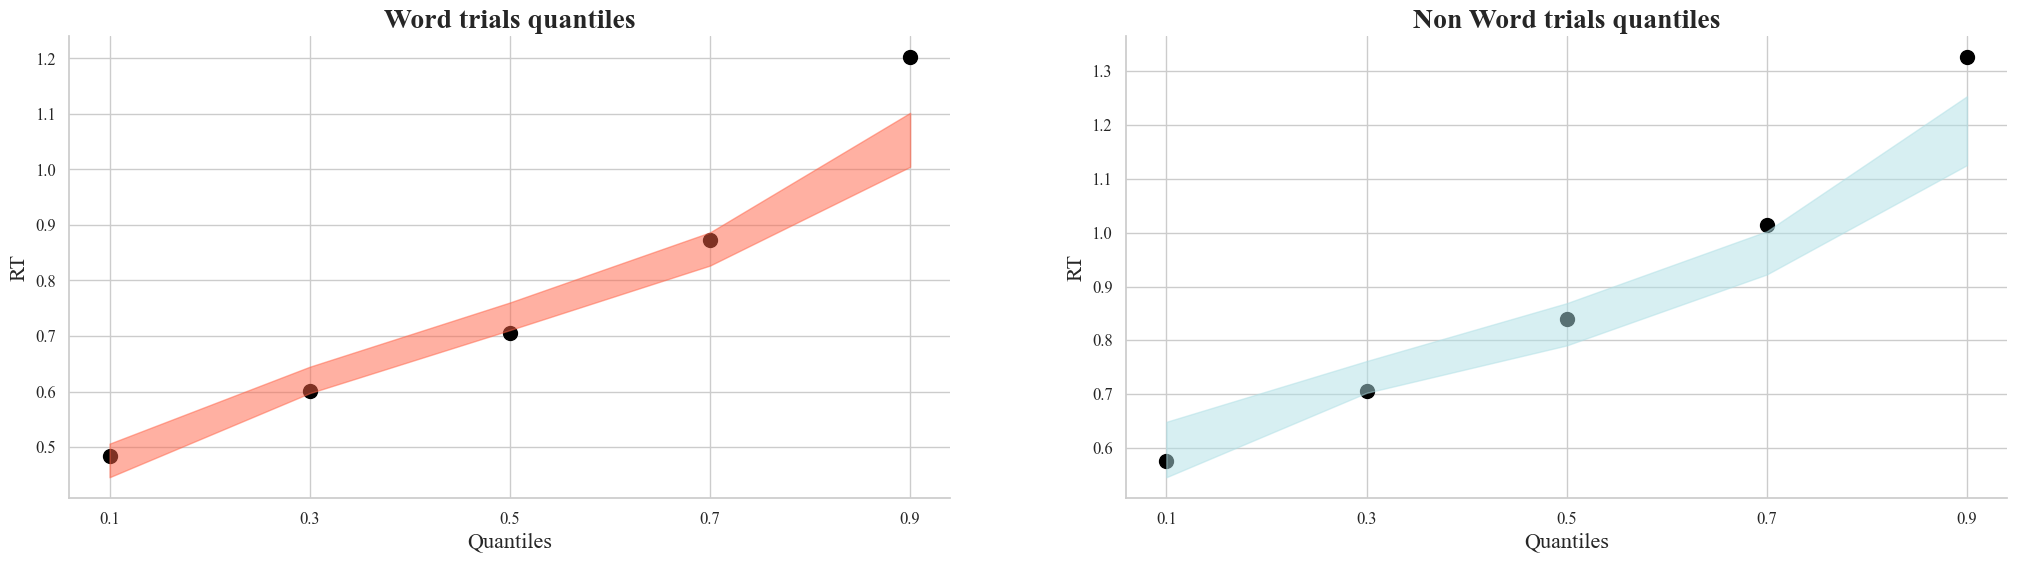

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(25,6))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

axes[0].set_title('Word trials quantiles', fontweight="bold", size=20)
axes[1].set_title('Non Word trials quantiles', fontweight="bold", size=20)

axes[0].scatter(quantiles, word_quantiles_ex, color='black', s=100)
axes[1].scatter(quantiles, nonword_quantiles_ex, color='black', s=100)

axes[0].fill_between(quantiles,
                word_predicted_bci[:, 0],
                word_predicted_bci[:, 1],
                word_predicted_bci[:, 0] < word_predicted_bci[:, 1],  color = 'tomato', alpha=0.5)

axes[1].fill_between(quantiles,
                nonword_predicted_bci[:, 0],
                nonword_predicted_bci[:, 1],
                nonword_predicted_bci[:, 0] < nonword_predicted_bci[:, 1],  color = 'powderblue', alpha=0.5)

for ax in axes:
        ax.set_xlabel('Quantiles', fontsize=16)
        ax.set_xticks(quantiles)
        ax.set_xticklabels(quantiles)
        ax.set_ylabel('RT', fontsize=16)
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(12)
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(12) 

sns.despine()
plt.savefig(plots_path + 'PPC-Quantiles-All Trials-Word vs Nonword.pdf')

### All trials (Correct Choice vs Incorrect Choice) 

In [47]:
exp_cor_choice_all, _ = GetDfs(accuracy=1)
exp_incor_resp_all, _ = GetDfs(accuracy=0)
pred_cor_choice_all = predictedData['rt'][predictedData['response']==behavioural_df['label']]
pred_incor_choice_all = predictedData['rt'][predictedData['response']!=behavioural_df['label']]

In [48]:
cor_quantiles_ex = exp_cor_choice_all['rt'].quantile(quantiles)
incor_quantiles_ex = exp_incor_resp_all['rt'].quantile(quantiles)

cor_quantiles_pred = pred_cor_choice_all.quantile(quantiles, axis=1).T
incor_quantiles_pred = pred_incor_choice_all.quantile(quantiles, axis=1).T

cor_predicted_bci = np.array([bci(cor_quantiles_pred[x]) for x in quantiles])
incor_predicted_bci = np.array([bci(incor_quantiles_pred[x]) for x in quantiles])

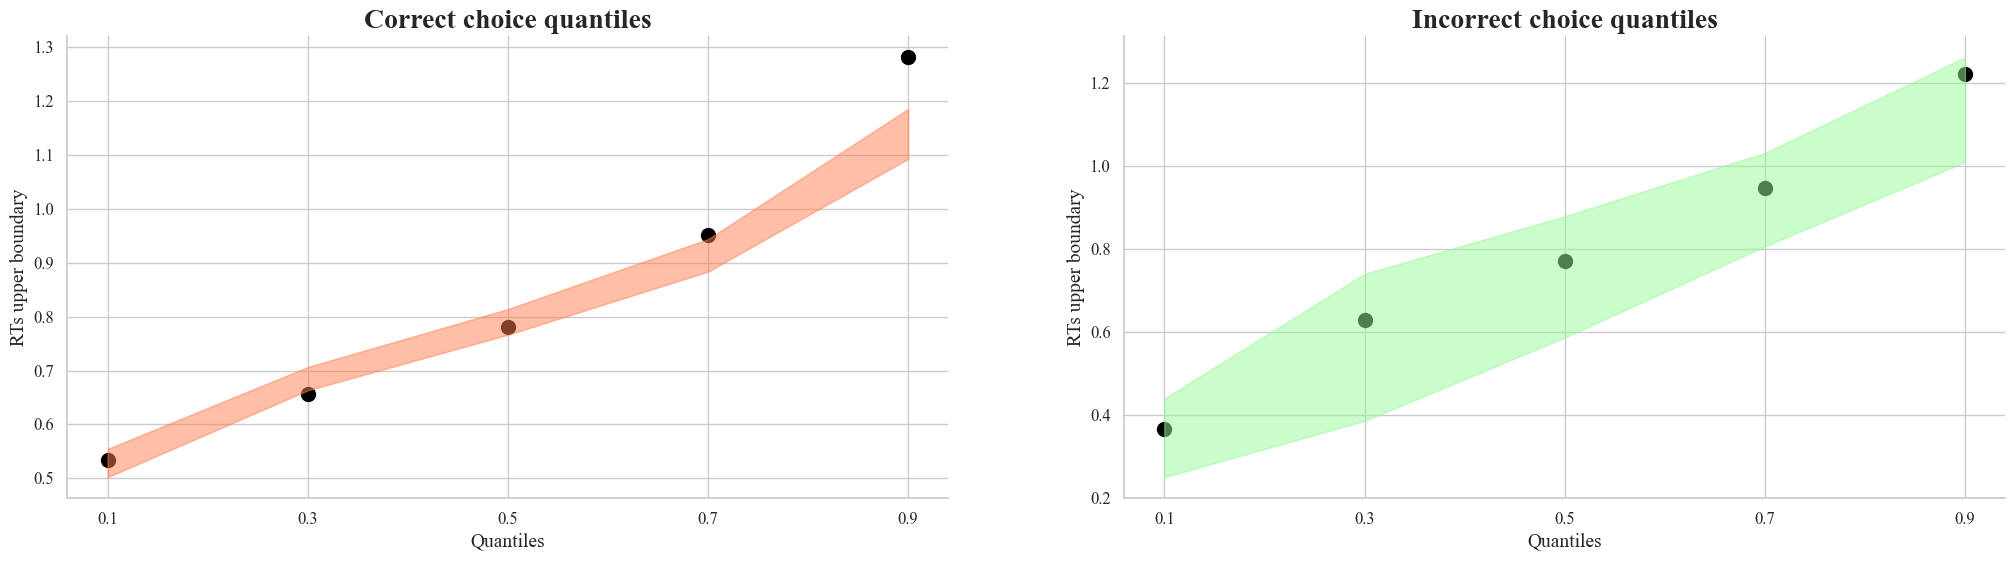

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(25,6))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

axes[0].set_title('Correct choice quantiles', fontweight="bold", size=20)
axes[1].set_title('Incorrect choice quantiles', fontweight="bold", size=20)

axes[0].scatter(quantiles, cor_quantiles_ex, color='black', s=100)
axes[1].scatter(quantiles, incor_quantiles_ex, color='black', s=100)

axes[0].fill_between(quantiles,
                cor_predicted_bci[:, 0],
                cor_predicted_bci[:, 1],
                cor_predicted_bci[:, 0] < cor_predicted_bci[:, 1],  color = 'coral', alpha=0.5)

axes[1].fill_between(quantiles,
                incor_predicted_bci[:, 0],
                incor_predicted_bci[:, 1],
                incor_predicted_bci[:, 0] < incor_predicted_bci[:, 1],  color = 'palegreen', alpha=0.5)

for ax in axes:
        ax.set_xlabel('Quantiles', fontsize=14)
        ax.set_xticks(quantiles)
        ax.set_xticklabels(quantiles)
        ax.set_ylabel('RTs upper boundary', fontsize=14)
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(12)
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(12) 

sns.despine()
plt.savefig(plots_path + 'PPC-Quantiles-All Trials-Correct vs Incorrect.pdf')

### Conditional (HF, LF, NW trials)

In [50]:
exp_HF_trials, pred_HF_trials = GetDfs(category="HF")
exp_LF_trials, pred_LF_trials = GetDfs(category="LF")
exp_NW_trials, pred_NW_trials = GetDfs(category="NW")

In [51]:
# experiment Data quantile
HF_quantile_ex = exp_HF_trials['rt'].quantile(quantiles)
LF_quantile_ex = exp_LF_trials['rt'].quantile(quantiles)
NW_quantile_ex = exp_NW_trials['rt'].quantile(quantiles)

# predicted data quantiles (for each sample)
HF_quantile_pred = pred_HF_trials.quantile(quantiles, axis=1).T
LF_quantile_pred = pred_LF_trials.quantile(quantiles, axis=1).T
NW_quantile_pred = pred_NW_trials.quantile(quantiles, axis=1).T

# predicted data quantiles bci
HF_predicted_bci = np.array([bci(HF_quantile_pred[x]) for x in quantiles])
LF_predicted_bci = np.array([bci(LF_quantile_pred[x]) for x in quantiles])
NW_predicted_bci = np.array([bci(NW_quantile_pred[x]) for x in quantiles])

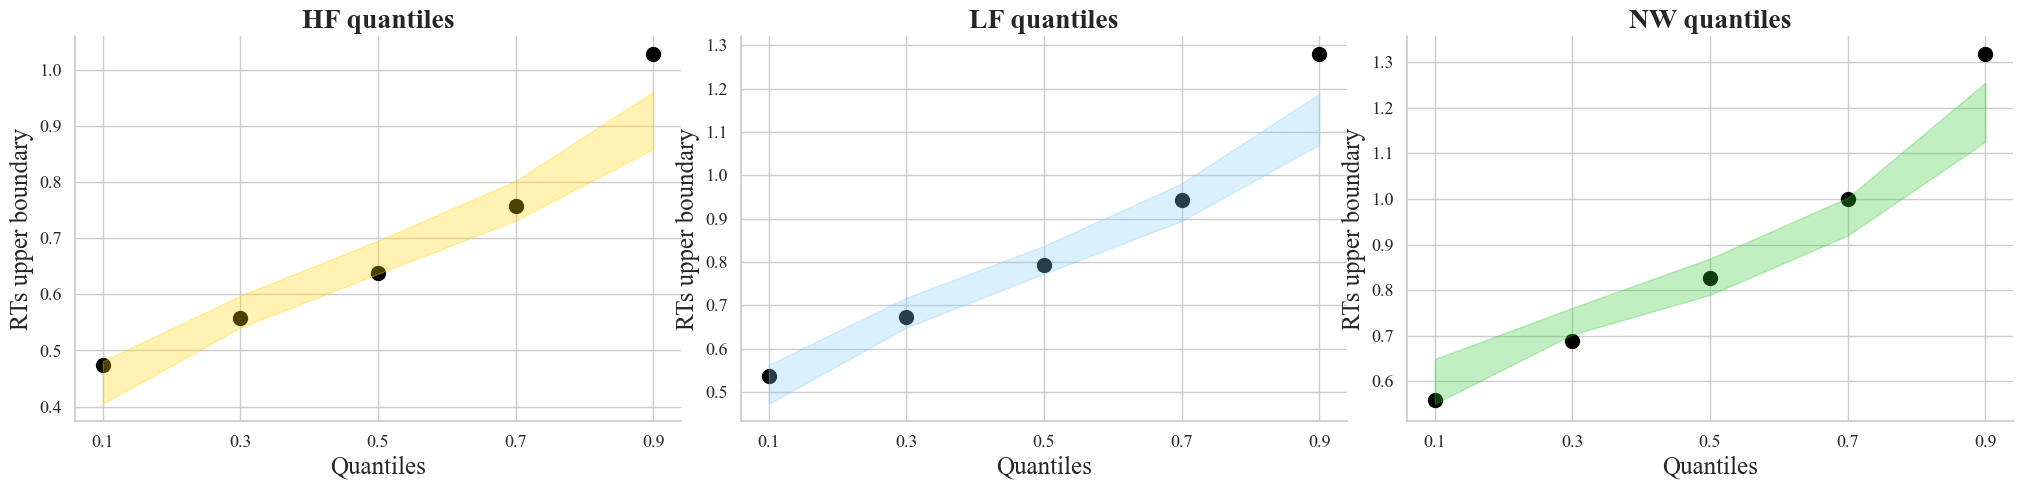

In [52]:
fig, axes = plt.subplots(1,3 , figsize=(25,5))
plt.subplots_adjust(wspace=0.1, hspace=0.5)

axes[0].set_title('HF quantiles', fontweight="bold", size=20)
axes[1].set_title('LF quantiles', fontweight="bold", size=20)
axes[2].set_title('NW quantiles', fontweight="bold", size=20)

axes[0].scatter(quantiles, HF_quantile_ex, color='black', s=100)
axes[1].scatter(quantiles, LF_quantile_ex, color='black', s=100)
axes[2].scatter(quantiles, NW_quantile_ex, color='black', s=100)

axes[0].fill_between(quantiles,
                HF_predicted_bci[:, 0],
                HF_predicted_bci[:, 1],
                HF_predicted_bci[:, 0] < HF_predicted_bci[:, 1],  color = 'gold', alpha=0.3)

axes[1].fill_between(quantiles,
                LF_predicted_bci[:, 0],
                LF_predicted_bci[:, 1],
                LF_predicted_bci[:, 0] < LF_predicted_bci[:, 1],  color = 'lightskyblue', alpha=0.3)

axes[2].fill_between(quantiles,
                NW_predicted_bci[:, 0],
                NW_predicted_bci[:, 1],
                NW_predicted_bci[:, 0] < NW_predicted_bci[:, 1],  color = 'limegreen', alpha=0.3)


for ax in axes:
        ax.set_xlabel('Quantiles', fontsize=18)
        ax.set_xticks(quantiles)
        ax.set_xticklabels(quantiles)
        ax.set_ylabel('RTs upper boundary', fontsize=18)
        for tick in ax.xaxis.get_major_ticks():
                tick.label1.set_fontsize(13)
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(13) 

sns.despine()
plt.savefig(plots_path + 'PPC-Quantiles-Conditional.pdf')

### Conditional (HF, LF, NW trials) for word response and nonword response

In [53]:
exp_word_resp_HF, pred_word_resp_HF = GetDfs(category="HF", response=1)
exp_word_resp_LF, pred_word_resp_LF = GetDfs(category="LF", response=1)
exp_word_resp_NW, pred_word_resp_NW = GetDfs(category="NW", response=1)

exp_nonword_resp_HF, pred_nonword_resp_HF = GetDfs(category="HF", response=0)
exp_nonword_resp_LF, pred_nonword_resp_LF = GetDfs(category="LF", response=0)
exp_nonword_resp_NW, pred_nonword_resp_NW = GetDfs(category="NW", response=0)

In [54]:
# experiment Data quantile
HF_word_quantile_ex = exp_word_resp_HF['rt'].quantile(quantiles)
LF_word_quantile_ex = exp_word_resp_LF['rt'].quantile(quantiles)
NW_word_quantile_ex = exp_word_resp_NW['rt'].quantile(quantiles)

HF_nonword_quantile_ex = exp_nonword_resp_HF['rt'].quantile(quantiles)
LF_nonword_quantile_ex = exp_nonword_resp_LF['rt'].quantile(quantiles)
NW_nonword_quantile_ex = exp_nonword_resp_NW['rt'].quantile(quantiles)

# predicted data quantiles (for each sample)
HF_word_quantile_pred = pred_word_resp_HF.quantile(quantiles, axis=1).T
LF_word_quantile_pred = pred_word_resp_LF.quantile(quantiles, axis=1).T
NW_word_quantile_pred = pred_word_resp_NW.quantile(quantiles, axis=1).T

HF_nonword_quantile_pred = pred_nonword_resp_HF.quantile(quantiles, axis=1).T
LF_nonword_quantile_pred = pred_nonword_resp_LF.quantile(quantiles, axis=1).T
NW_nonword_quantile_pred = pred_nonword_resp_NW.quantile(quantiles, axis=1).T


# predicted data quantiles bci
HF_word_predicted_bci = np.array([bci(HF_word_quantile_pred[x]) for x in quantiles])
LF_word_predicted_bci = np.array([bci(LF_word_quantile_pred[x]) for x in quantiles])
NW_word_predicted_bci = np.array([bci(NW_word_quantile_pred[x]) for x in quantiles])

HF_nonword_predicted_bci = np.array([bci(HF_nonword_quantile_pred[x]) for x in quantiles])
LF_nonword_predicted_bci = np.array([bci(LF_nonword_quantile_pred[x]) for x in quantiles])
NW_nonword_predicted_bci = np.array([bci(NW_nonword_quantile_pred[x]) for x in quantiles])

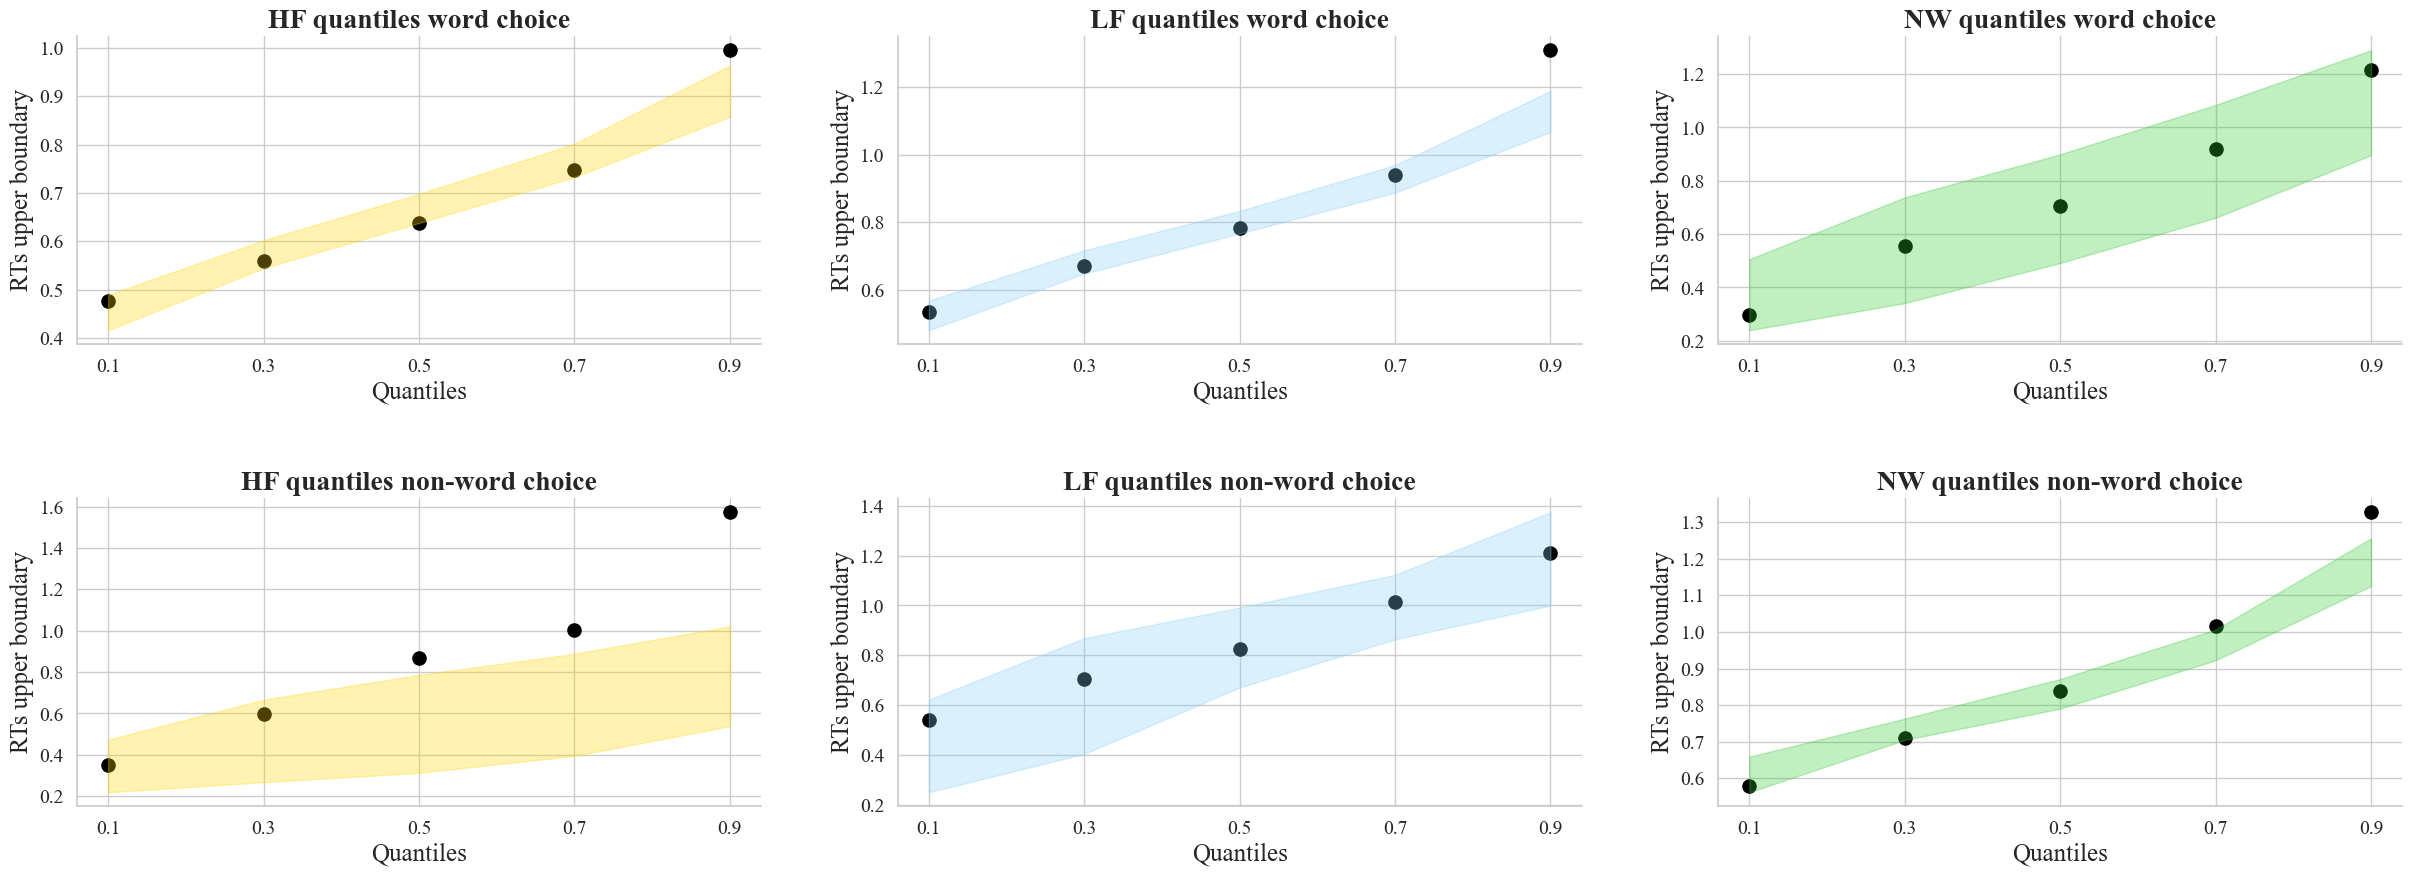

In [55]:
fig, axes = plt.subplots(2,3 , figsize=(30,10))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

axes[0][0].set_title('HF quantiles word choice', fontweight="bold", size=20)
axes[0][1].set_title('LF quantiles word choice', fontweight="bold", size=20)
axes[0][2].set_title('NW quantiles word choice', fontweight="bold", size=20)

axes[1][0].set_title('HF quantiles non-word choice', fontweight="bold", size=20)
axes[1][1].set_title('LF quantiles non-word choice', fontweight="bold", size=20)
axes[1][2].set_title('NW quantiles non-word choice', fontweight="bold", size=20)

axes[0][0].scatter(quantiles, HF_word_quantile_ex, color='black', s=90)
axes[0][1].scatter(quantiles, LF_word_quantile_ex, color='black', s=90)
axes[0][2].scatter(quantiles, NW_word_quantile_ex, color='black', s=90)

axes[1][0].scatter(quantiles, HF_nonword_quantile_ex, color='black', s=90)
axes[1][1].scatter(quantiles, LF_nonword_quantile_ex, color='black', s=90)
axes[1][2].scatter(quantiles, NW_nonword_quantile_ex, color='black', s=90)


axes[0][0].fill_between(quantiles,
                HF_word_predicted_bci[:, 0],
                HF_word_predicted_bci[:, 1],
                HF_word_predicted_bci[:, 0] < HF_word_predicted_bci[:, 1],  color = 'gold', alpha=0.3)

axes[0][1].fill_between(quantiles,
                LF_word_predicted_bci[:, 0],
                LF_word_predicted_bci[:, 1],
                LF_word_predicted_bci[:, 0] < LF_word_predicted_bci[:, 1],  color = 'lightskyblue', alpha=0.3)

axes[0][2].fill_between(quantiles,
                NW_word_predicted_bci[:, 0],
                NW_word_predicted_bci[:, 1],
                NW_word_predicted_bci[:, 0] < NW_word_predicted_bci[:, 1],  color = 'limegreen', alpha=0.3)


axes[1][0].fill_between(quantiles,
                HF_nonword_predicted_bci[:, 0],
                HF_nonword_predicted_bci[:, 1],
                HF_nonword_predicted_bci[:, 0] < HF_nonword_predicted_bci[:, 1],  color = 'gold', alpha=0.3)

axes[1][1].fill_between(quantiles,
                LF_nonword_predicted_bci[:, 0],
                LF_nonword_predicted_bci[:, 1],
                LF_nonword_predicted_bci[:, 0] < LF_nonword_predicted_bci[:, 1],  color = 'lightskyblue', alpha=0.3)

axes[1][2].fill_between(quantiles,
                NW_nonword_predicted_bci[:, 0],
                NW_nonword_predicted_bci[:, 1],
                NW_nonword_predicted_bci[:, 0] < NW_nonword_predicted_bci[:, 1],  color = 'limegreen', alpha=0.3)


for ax_d1 in axes:
    for ax in ax_d1:
        ax.set_xlabel('Quantiles', fontsize=18)
        ax.set_xticks(quantiles)
        ax.set_xticklabels(quantiles)
        ax.set_ylabel('RTs upper boundary', fontsize=18)
        for tick in ax.xaxis.get_major_ticks():
                tick.label1.set_fontsize(14)
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(14) 

sns.despine()
plt.savefig(plots_path + 'PPC-Quantiles-Conditional-Word vs Nonword.pdf')

## Mean Accuracy and RT Posterior Prediction Checks


In [56]:
def plot_posterior(x, data_mean, ax):
    """
    Plots the posterior of x with experimental data mean as a line
    
    Parameters
    ----------
    x : array-like
        An array containing RT or response for each trial.
        
    x : float
        mean of RT or Accuracy of experimental data.

    ax : matplotlib.axes.Axes
        
    Returns
    -------
    None
    """
    density = gaussian_kde(x, bw_method='scott')
    xd = np.linspace(x.min(), x.max())
    yd = density(xd)

    low, high = bci(x)
    ax.fill_between(xd[np.logical_and(xd >= low, xd <= high)],
                     yd[np.logical_and(xd >= low, xd <= high)], color = 'lightsteelblue')

    ax.plot(xd, yd, color='slategray')
    ax.axvline(data_mean, color='red')

### All trials

In [57]:
exp_all_trials_rt, pred_all_trials_rt = GetDfs()
exp_all_trials_resp, pred_all_trials_resp = GetDfs(pred_df_type='response')

In [58]:
all_data_rt_mean = exp_all_trials_rt['rt'].mean()
all_pred_rt_mean = pred_all_trials_rt.mean(axis=1)

all_data_resp_mean = exp_all_trials_resp['response'].mean()
all_pred_resp_mean = pred_all_trials_resp.mean(axis=1)

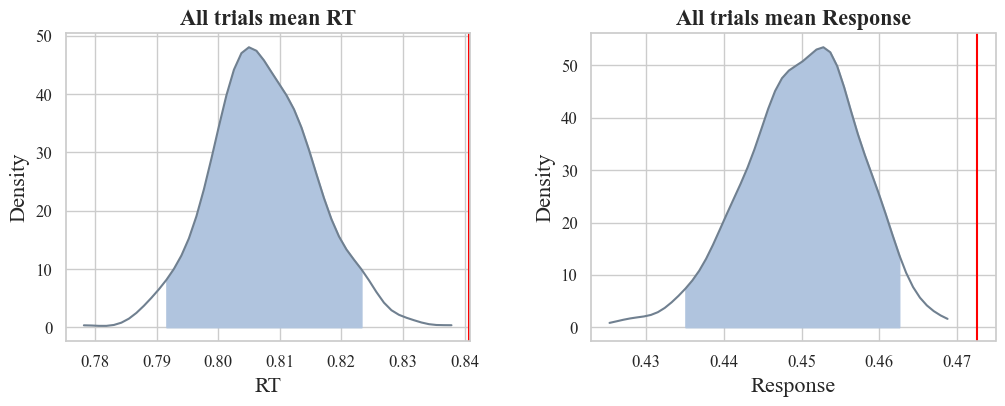

In [59]:
fig, axes = plt.subplots(1,2 , figsize=(12, 4))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

axes[0].set_title('All trials mean RT', fontweight="bold", size=16)
axes[1].set_title('All trials mean Response', fontweight="bold", size=16)

plot_posterior(all_pred_rt_mean, all_data_rt_mean, axes[0])
plot_posterior(all_pred_resp_mean, all_data_resp_mean, axes[1])

axes[0].set_xlabel('RT', fontsize=16)
axes[1].set_xlabel('Response', fontsize=16)

for ax in axes:
        ax.set_ylabel('Density', fontsize=16)
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(12)
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(12)
            
plt.savefig(plots_path + 'PPC-Mean Accuracy and RT-All trials.pdf')

### All Trials (correct choice vs incorrect choice)

In [60]:
exp_cor_all_trials_rt, pred_cor_all_trials_rt = GetDfs(accuracy=1)
exp_incor_all_trials_rt, pred_incor_all_trials_rt = GetDfs(accuracy=0)

exp_cor_all_trials_resp, pred_cor_all_trials_resp = GetDfs(accuracy=1,
                                                             pred_df_type='response')
exp_incor_all_trials_resp, pred_incor_all_trials_resp = GetDfs(accuracy=0,
                                                             pred_df_type='response')

In [61]:
all_trials_cor_rt_mean = exp_cor_all_trials_rt['rt'].mean()
all_pred_cor_rt_mean = pred_cor_all_trials_rt.mean(axis=1)

all_trials_incor_rt_mean = exp_incor_all_trials_rt['rt'].mean()
all_pred_incor_rt_mean = pred_incor_all_trials_rt.mean(axis=1)


all_data_cor_resp_mean = exp_cor_all_trials_resp['response'].mean()
all_pred_cor_resp_mean = pred_cor_all_trials_resp.mean(axis=1)

all_data_incor_resp_mean = exp_incor_all_trials_resp['response'].mean()
all_pred_incor_resp_mean = pred_incor_all_trials_resp.mean(axis=1)

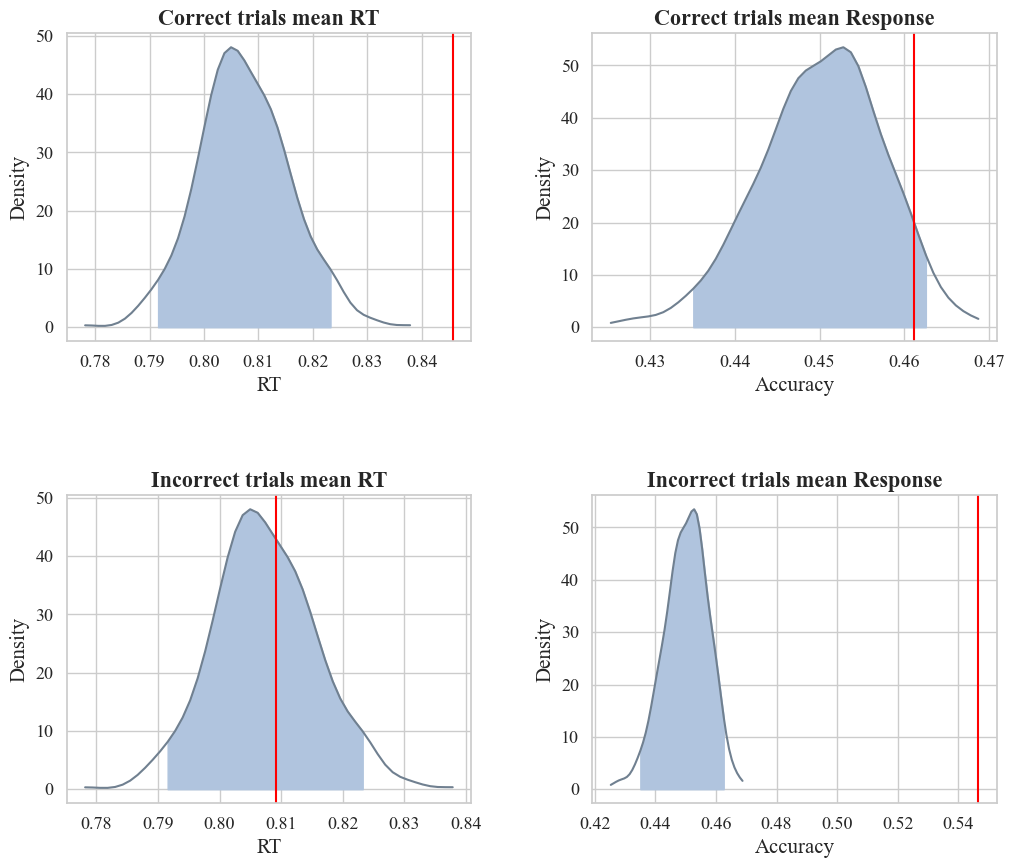

In [62]:
fig, axes = plt.subplots(2,2 , figsize=(12,10))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

axes[0][0].set_title('Correct trials mean RT', fontweight="bold", size=16)
axes[0][1].set_title('Correct trials mean Response', fontweight="bold", size=16)
axes[1][0].set_title('Incorrect trials mean RT', fontweight="bold", size=16)
axes[1][1].set_title('Incorrect trials mean Response', fontweight="bold", size=16)

plot_posterior(all_pred_cor_rt_mean, all_trials_cor_rt_mean, axes[0][0])
plot_posterior(all_pred_cor_resp_mean, all_data_cor_resp_mean, axes[0][1])

plot_posterior(all_pred_incor_rt_mean, all_trials_incor_rt_mean, axes[1][0])
plot_posterior(all_pred_incor_resp_mean, all_data_incor_resp_mean, axes[1][1])

for ax in axes:
        ax[0].set_xlabel('RT', fontsize=15)
        ax[1].set_xlabel('Accuracy', fontsize=15)
        ax[0].set_ylabel('Density', fontsize=15)
        ax[1].set_ylabel('Density', fontsize=15)
        for tick in ax[0].xaxis.get_major_ticks():
            tick.label1.set_fontsize(13)
        for tick in ax[0].yaxis.get_major_ticks():
            tick.label1.set_fontsize(13)
        for tick in ax[1].xaxis.get_major_ticks():
            tick.label1.set_fontsize(13)
        for tick in ax[1].yaxis.get_major_ticks():
            tick.label1.set_fontsize(13) 

plt.savefig(plots_path + 'PPC-Mean Accuracy and RT-All trials-Correct vs Incorrect.pdf')

### Conditional (HF, LF, NW trials) 

In [63]:
exp_HF_trials_rt, pred_HF_trials_rt = GetDfs(category="HF")
exp_LF_trials_rt, pred_LF_trials_rt = GetDfs(category="LF")
exp_NW_trials_rt, pred_NW_trials_rt = GetDfs(category="NW")

exp_HF_trials_resp, pred_HF_trials_resp = GetDfs(category="HF", pred_df_type='response')
exp_LF_trials_resp, pred_LF_trials_resp = GetDfs(category="LF", pred_df_type='response')
exp_NW_trials_resp, pred_NW_trials_resp = GetDfs(category="NW", pred_df_type='response')

In [64]:
HF_data_rt_mean = exp_HF_trials_rt['rt'].mean()
LF_data_rt_mean = exp_LF_trials_rt['rt'].mean()
NW_data_rt_mean = exp_NW_trials_rt['rt'].mean()

HF_pred_rt_mean = pred_HF_trials_rt.mean(axis=1)
LF_pred_rt_mean = pred_LF_trials_rt.mean(axis=1)
NW_pred_rt_mean = pred_NW_trials_rt.mean(axis=1)


HF_data_resp_mean = exp_HF_trials_resp['response'].mean()
LF_data_resp_mean = exp_LF_trials_resp['response'].mean()
NW_data_resp_mean = exp_NW_trials_resp['response'].mean()

HF_pred_resp_mean = pred_HF_trials_resp.mean(axis=1)
LF_pred_resp_mean = pred_LF_trials_resp.mean(axis=1)
NW_pred_resp_mean = pred_NW_trials_resp.mean(axis=1)


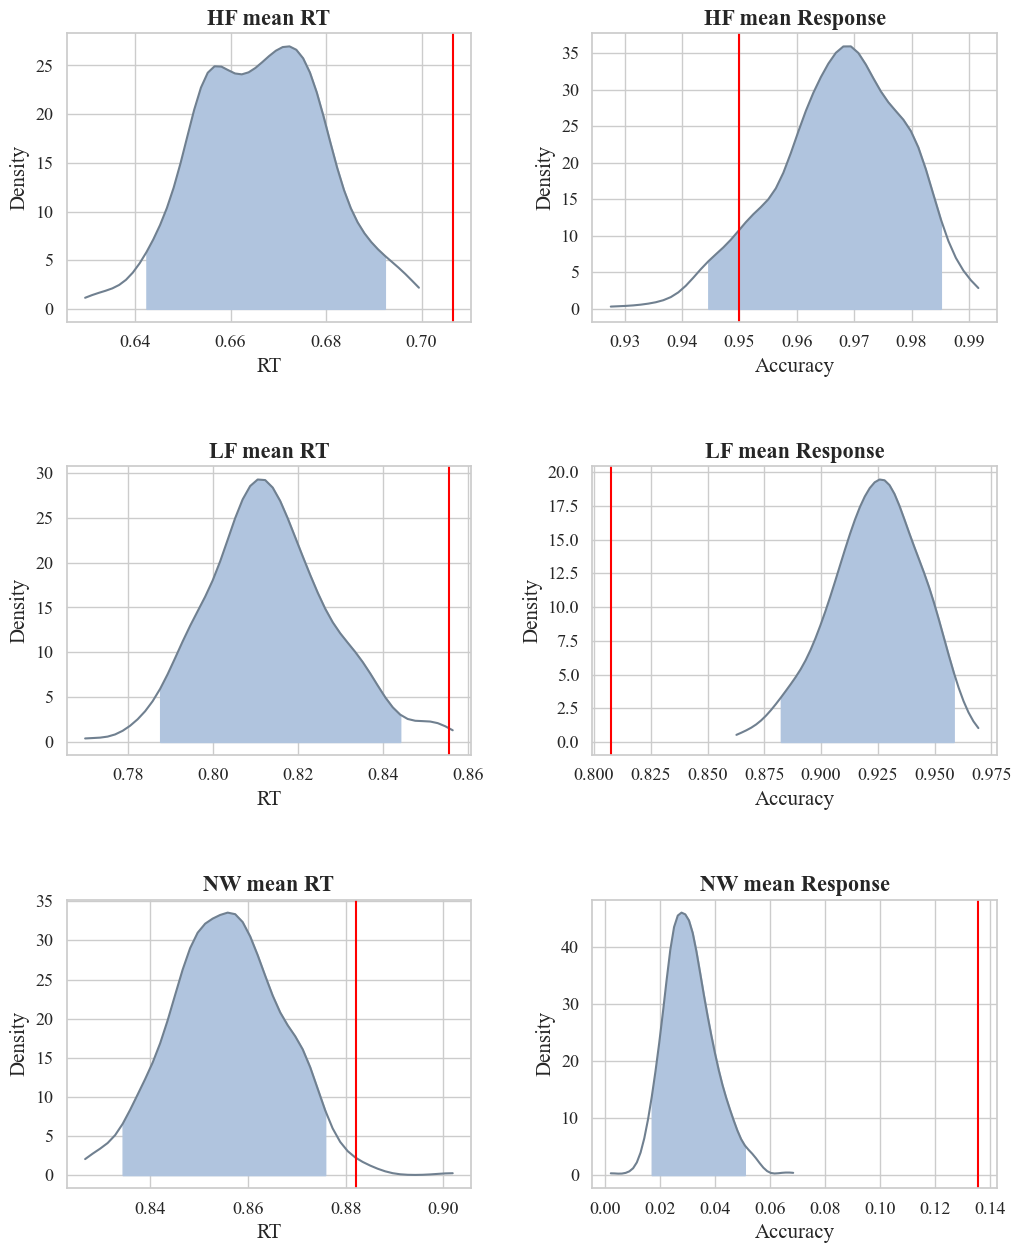

In [65]:
fig, axes = plt.subplots(3,2 , figsize=(12,15))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

axes[0][0].set_title('HF mean RT', fontweight="bold", size=16)
axes[0][1].set_title('HF mean Response', fontweight="bold", size=16)
axes[1][0].set_title('LF mean RT', fontweight="bold", size=16)
axes[1][1].set_title('LF mean Response', fontweight="bold", size=16)
axes[2][0].set_title('NW mean RT', fontweight="bold", size=16)
axes[2][1].set_title('NW mean Response', fontweight="bold", size=16)

plot_posterior(HF_pred_rt_mean, HF_data_rt_mean, axes[0][0])
plot_posterior(HF_pred_resp_mean, HF_data_resp_mean, axes[0][1])

plot_posterior(LF_pred_rt_mean, LF_data_rt_mean, axes[1][0])
plot_posterior(LF_pred_resp_mean, LF_data_resp_mean, axes[1][1])

plot_posterior(NW_pred_rt_mean, NW_data_rt_mean, axes[2][0])
plot_posterior(NW_pred_resp_mean, NW_data_resp_mean, axes[2][1])

for ax in axes:
        ax[0].set_xlabel('RT', fontsize=15)
        ax[1].set_xlabel('Accuracy', fontsize=15)
        ax[0].set_ylabel('Density', fontsize=15)
        ax[1].set_ylabel('Density', fontsize=15)
        for tick in ax[0].xaxis.get_major_ticks():
            tick.label1.set_fontsize(13)
        for tick in ax[0].yaxis.get_major_ticks():
            tick.label1.set_fontsize(13)
        for tick in ax[1].xaxis.get_major_ticks():
            tick.label1.set_fontsize(13)
        for tick in ax[1].yaxis.get_major_ticks():
            tick.label1.set_fontsize(13) 

plt.savefig(plots_path + 'PPC-Mean Accuracy and RT-Conditional.pdf')